<a href="https://colab.research.google.com/gist/IamA1ive/c95fcdf75ec5dfed09725124857258e2/ml-student-performance-predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Student Performance Predictions
Задача: спрогнозировать результаты учащихся на основе различных академических и поведенческих факторов.
Датасет содержит случайные пропущенные значения и преднамеренные ошибки данных, что делает его более реалистичным для практики очистки и предварительной обработки данных.

In [157]:
import kagglehub
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns


# Загружаем последнюю версию датасета с kaggle.com
path = kagglehub.dataset_download("haseebindata/student-performance-predictions")

print("Расположение датасета:", path)
df = pd.read_csv(os.path.join(path, "student_performance_updated_1000.csv"))

Using Colab cache for faster access to the 'student-performance-predictions' dataset.
Расположение датасета: /kaggle/input/student-performance-predictions


Прочитаем данные

In [158]:
print("\nРазмерность набора данных:", df.shape)
print("\nОбщая информация о наборе данных:\n")
df.info()
print("\nПервые и последние 5 строк набора данных:")
display(df.head())
display(df.tail())



Размерность набора данных: (1000, 12)

Общая информация о наборе данных:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   StudentID                  960 non-null    float64
 1   Name                       966 non-null    object 
 2   Gender                     952 non-null    object 
 3   AttendanceRate             960 non-null    float64
 4   StudyHoursPerWeek          950 non-null    float64
 5   PreviousGrade              967 non-null    float64
 6   ExtracurricularActivities  957 non-null    float64
 7   ParentalSupport            978 non-null    object 
 8   FinalGrade                 960 non-null    float64
 9   Study Hours                976 non-null    float64
 10  Attendance (%)             959 non-null    float64
 11  Online Classes Taken       975 non-null    object 
dtypes: float64(8), object(4)
memor

,StudentID,Name,Gender,AttendanceRate,StudyHoursPerWeek,PreviousGrade,ExtracurricularActivities,ParentalSupport,FinalGrade,Study Hours,Attendance (%),Online Classes Taken
0,1.0,John,Male,85.0,15.0,78.0,1.0,High,80.0,4.8,59.0,False
1,2.0,Sarah,Female,90.0,20.0,85.0,2.0,Medium,87.0,2.2,70.0,True
2,3.0,Alex,Male,78.0,10.0,65.0,0.0,Low,68.0,4.6,92.0,False
3,4.0,Michael,Male,92.0,25.0,90.0,3.0,High,92.0,2.9,96.0,False
4,5.0,Emma,Female,NaN,18.0,82.0,2.0,Medium,85.0,4.1,97.0,True


,StudentID,Name,Gender,AttendanceRate,StudyHoursPerWeek,PreviousGrade,ExtracurricularActivities,ParentalSupport,FinalGrade,Study Hours,Attendance (%),Online Classes Taken
995,NaN,Kenneth Murray,Male,85.0,20.0,NaN,1.0,High,72.0,0.8,80.0,True
996,4497.0,Amy Stout,Female,91.0,NaN,86.0,0.0,High,90.0,3.9,80.0,True
997,1886.0,NaN,Male,85.0,8.0,82.0,2.0,Low,68.0,0.4,54.0,False
998,7636.0,Joseph Sherman,Male,88.0,17.0,60.0,2.0,High,85.0,0.9,53.0,True
999,8021.0,Maria Walls,Female,88.0,10.0,90.0,1.0,Medium,NaN,2.4,94.0,True


Имеем:

`StudentID`	- уникальный номер каждого студента

`Name` - имя студента

`Gender` - пол студента (Male / Female)

`AttendanceRate` - общая оценка посещаемости

`StudyHoursPerWeek` - часы, затрачиваемые на обучение еженедельно

`PreviousGrade` - оценка с прошлого семестра

`ExtracurricularActivities` - количество внеклассных мероприятий

`ParentalSupport` - уровень родительской поддержки (High / Medium / Low)

`FinalGrade` - итоговая оценка (целевая для предсказания переменная)

`Study Hours` - часы, затрачиваемые на обучение ежедневно

`Attendance` (%) - доля посещённых занятий

`Online Classes Taken` - посещал ли студент онлайн-занятия (True / False).

In [159]:
print("Количество пропущенных значений:")
display(df.isnull().sum())
display(df.describe())

Количество пропущенных значений:


,0
StudentID,40
Name,34
Gender,48
AttendanceRate,40
StudyHoursPerWeek,50
PreviousGrade,33
ExtracurricularActivities,43
ParentalSupport,22
FinalGrade,40
Study Hours,24


,StudentID,AttendanceRate,StudyHoursPerWeek,PreviousGrade,ExtracurricularActivities,FinalGrade,Study Hours,Attendance (%)
count,960.000000,960.000000,950.000000,967.000000,957.000000,960.000000,976.000000,959.000000
mean,5416.019792,85.510417,17.630526,77.598759,1.520376,80.030208,2.406967,77.248175
std,2653.748319,7.332125,6.272132,10.006640,1.046439,9.493652,1.620267,19.298148
min,1.000000,70.000000,8.000000,60.000000,0.000000,62.000000,-5.000000,50.000000
25%,3113.500000,82.000000,12.000000,70.000000,1.000000,72.000000,1.200000,63.000000
50%,5396.500000,88.000000,18.000000,78.000000,1.000000,80.000000,2.500000,76.000000
75%,7754.750000,91.000000,22.000000,86.000000,2.000000,88.000000,3.700000,89.000000
max,9998.000000,95.000000,30.000000,90.000000,3.000000,92.000000,5.000000,200.000000


Обработаем пропущенные значения

In [160]:
# Найдём дубликаты
print("Количество одинаковых строк:", df.duplicated().sum())
print("Процент уникальных имён:", round(100 * df["Name"].dropna().nunique() / len(df["Name"].dropna()), 2), "%")
# Удалим пропущенные значения
print("Процент строк с пропущенными значениями:", 100 * (1 - len(df.dropna()) / len(df)), "%")

Количество одинаковых строк: 0
Процент уникальных имён: 99.59 %
Процент строк с пропущенными значениями: 35.5 %


Видим, что строки с пропущенными значениями занимают значительную часть всего датасета и строк в таблице станет намного меньше после их удаления.

Для нашего датасета это критично, поэтому для того, чтобы минимизировать ущерб от наличия пропущенных значений, вместо удаления сотен строк из датасета - удалим столбцы `id` и `name`, так как в них содержится большое количество пропущенных значений, но сами признаки при этом не влияют на оценку студента.
Это позволит упростить модель и избежать использования нерелевантных данных на этапе обучения. Для остальных числовых признаков заменим пропущенные значения на медиану.

In [161]:
df = df.drop("Name", axis=1).drop("StudentID", axis=1)
numerical_cols = df.select_dtypes(include='float64').columns
for col in numerical_cols:
    df[col] = df[col].fillna(df[col].median())

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Gender                     952 non-null    object 
 1   AttendanceRate             1000 non-null   float64
 2   StudyHoursPerWeek          1000 non-null   float64
 3   PreviousGrade              1000 non-null   float64
 4   ExtracurricularActivities  1000 non-null   float64
 5   ParentalSupport            978 non-null    object 
 6   FinalGrade                 1000 non-null   float64
 7   Study Hours                1000 non-null   float64
 8   Attendance (%)             1000 non-null   float64
 9   Online Classes Taken       975 non-null    object 
dtypes: float64(7), object(3)
memory usage: 78.3+ KB


Обработаем категориальные признаки

In [162]:
# Посмотрим на возможные значения категориальных признаков
categorical_cols = ["Gender", "ParentalSupport", "Online Classes Taken"]
for col in categorical_cols:
  print(df[col].unique())

['Male' 'Female' nan]
['High' 'Medium' 'Low' nan]
[False True nan]


In [167]:
# Заменим пропущенные значения категориальных признаков на моду
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Gender                     1000 non-null   object 
 1   AttendanceRate             1000 non-null   float64
 2   StudyHoursPerWeek          1000 non-null   float64
 3   PreviousGrade              1000 non-null   float64
 4   ExtracurricularActivities  1000 non-null   float64
 5   ParentalSupport            1000 non-null   object 
 6   FinalGrade                 1000 non-null   float64
 7   Study Hours                1000 non-null   float64
 8   Attendance (%)             1000 non-null   float64
 9   Online Classes Taken       1000 non-null   bool   
dtypes: bool(1), float64(7), object(2)
memory usage: 71.4+ KB


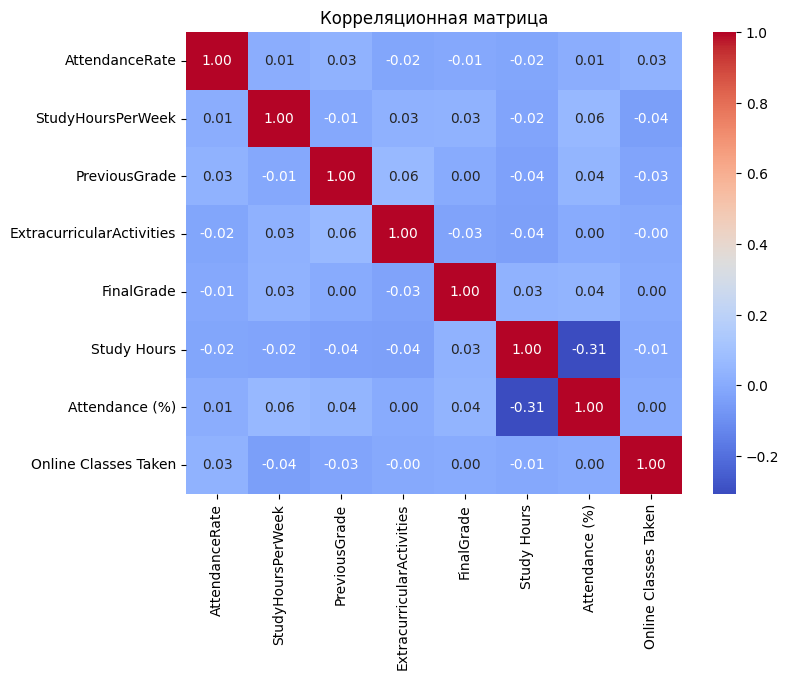

In [173]:
plt.figure(figsize=(8, 6))

corr_matrix = df.corr(numeric_only=True)

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Корреляционная матрица')
plt.show()